**This project aims to detect Covid-19 from X-ray images and distinguish it from viral and bacterial pneumonia. A custom dataset was created, comprising X-ray images of Covid-19 cases, viral pneumonia, bacterial pneumonia, and healthy individuals. Each class contains 133 images.**

## Dataset info

I utilized data from this https://github.com/ieee8023/covid-chestxray-dataset and https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia. The dataset is organized into four folders:

0 – Covid-19 X-ray  
1 – Normal X-ray  
2 – Viral Pneumonia X-ray  
3 – Bacterial Pneumonia X-ray  

## Import Libraries

In [1]:
import os
# import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, optimizers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

## Import Data

In [2]:
X_RAY_DIRECTORY = 'X-Ray_Images\Dataset'

In [3]:
os.listdir(X_RAY_DIRECTORY)

['0', '1', '2', '3']

### Split data (train/validation)

In [4]:
image_gen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [5]:
train_gen = image_gen.flow_from_directory(directory=X_RAY_DIRECTORY, 
                                          batch_size=40, 
                                          target_size=(255, 255), 
                                          shuffle=True,
                                          class_mode='categorical',
                                          subset='training')

Found 428 images belonging to 4 classes.


In [6]:
validation_gen = image_gen.flow_from_directory(directory=X_RAY_DIRECTORY, 
                                               batch_size=40, 
                                               target_size=(255, 255), 
                                               shuffle=True,
                                               class_mode='categorical',
                                               subset='validation')

Found 104 images belonging to 4 classes.


In [7]:
train_images, train_labels = next(train_gen)

In [8]:
train_images.shape

(40, 255, 255, 3)

In [9]:
train_labels.shape

(40, 4)

In [10]:
labels = {0: 'Covid-19', 1: 'Normal', 2: 'Viral Pneumonia', 3: 'Bacterial Pneumonia'}

### Data visualisation

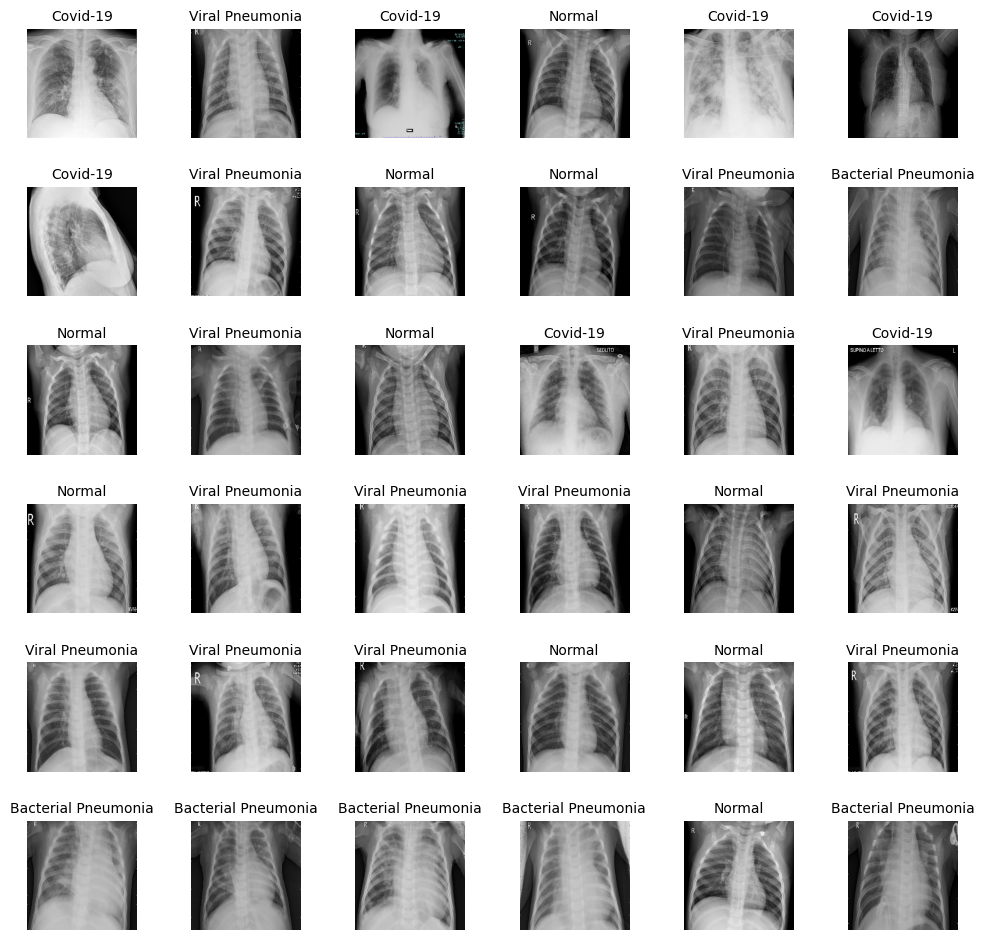

In [11]:
fig, axes = plt.subplots(6, 6, figsize=(12, 12))
axes = axes.ravel()  #flatten axes

for i in np.arange(6*6):
    axes[i].imshow(train_images[i])
    axes[i].set_title(labels[np.argmax(train_labels[i])], fontsize=10)
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

## Model

### Pretrained ResNet model uploading

In [12]:
# input_tensor = Input(shape=(256, 256, 3)) 

In [13]:
basemodel = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

In [14]:
basemodel.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 262, 262, 3)       │               0 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 128, 128, 64)      │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_bn (BatchNormalization) │ (None, 128, 128, 64)      │             256 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_relu (Activation)       │ (None, 128, 128, 64)      │               0 │ conv1_bn[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 130, 130, 64)      │               0 │ conv1_relu[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 64, 64, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 64, 64, 64)        │           4,160 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 64, 64, 64)        │          36,928 │ conv2_block1_1_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 64, 64, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 64, 64, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_0_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ pool1_pool[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_3_conv (Conv2D)  │ (None, 64, 64, 256)       │          16,640 │ conv2_block1_2_relu[0][0]  │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [15]:
# freeze layers
for layer in basemodel.layers[:-10]:
    layers.trainable = False   

### Add 10 top CNN layers to base model (ResNet50)

In [16]:
head = basemodel.output
head = AveragePooling2D(pool_size=(4,4))(head)
head = Flatten(name='flatten')(head)
head = Dense(256, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(200, activation='relu')(head)
head = Dropout(0.3)(head)
head = Dense(4, activation='softmax')(head)

In [17]:
model = Model(inputs=basemodel.input, outputs = head)

### Model compilation

In [18]:
model.compile(loss='categorical_crossentropy', optimizer= optimizers.RMSprop(), metrics=['accuracy'])

In [19]:
# validation error checking
early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=20)

In [20]:
# save best model (min val loss)
best_model_checkpoint = ModelCheckpoint(filepath = 'model_last_checkpoint.keras', verbose=1, save_best_only=True)

In [21]:
train_img_generator = image_gen.flow_from_directory(directory=X_RAY_DIRECTORY, 
                                                    batch_size=4, 
                                                    shuffle=True, 
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    subset='training')

Found 428 images belonging to 4 classes.


In [22]:
val_img_generator = image_gen.flow_from_directory(directory=X_RAY_DIRECTORY, 
                                                    batch_size=4, 
                                                    shuffle=True, 
                                                    target_size=(256, 256),
                                                    class_mode='categorical',
                                                    subset='validation')

Found 104 images belonging to 4 classes.


In [25]:
history = model.fit(train_img_generator, 
                              epochs=10, 
                              validation_data=val_img_generator,
                              callbacks=[best_model_checkpoint, early_stop])

Epoch 1/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 568ms/step - accuracy: 0.4645 - loss: 1.4275
Epoch 1: val_loss did not improve from 1.38808
107/107 ━━━━━━━━━━━━━━━━━━━━ 65s 605ms/step - accuracy: 0.4649 - loss: 1.4259 - val_accuracy: 0.2500 - val_loss: 3.3937
Epoch 2/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 566ms/step - accuracy: 0.5882 - loss: 1.0031
Epoch 2: val_loss did not improve from 1.38808
107/107 ━━━━━━━━━━━━━━━━━━━━ 64s 602ms/step - accuracy: 0.5879 - loss: 1.0036 - val_accuracy: 0.2404 - val_loss: 1.4203
Epoch 3/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 567ms/step - accuracy: 0.6232 - loss: 0.9217
Epoch 3: val_loss did not improve from 1.38808
107/107 ━━━━━━━━━━━━━━━━━━━━ 65s 603ms/step - accuracy: 0.6234 - loss: 0.9216 - val_accuracy: 0.2500 - val_loss: 8.8229
Epoch 4/10
107/107 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.6401 - loss: 0.9318
Epoch 4: val_loss did not improve from 1.38808
107/107 ━━━━━━━━━━━━━━━━━━━━ 65s 605ms/step - accuracy: 0.6403 - loss: 0.9317 - val_accuracy: 0.2596

### Model Evaluation

In [26]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Text(0, 0.5, 'Training accuracy and loss')

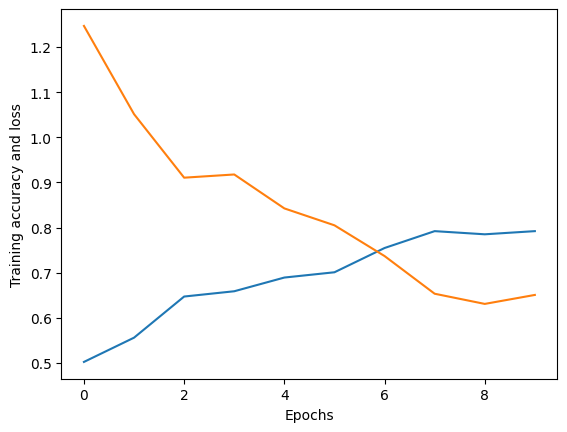

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['loss'])
plt.xlabel("Epochs")
plt.ylabel("Training accuracy and loss")

Text(0, 0.5, 'Validation loss')

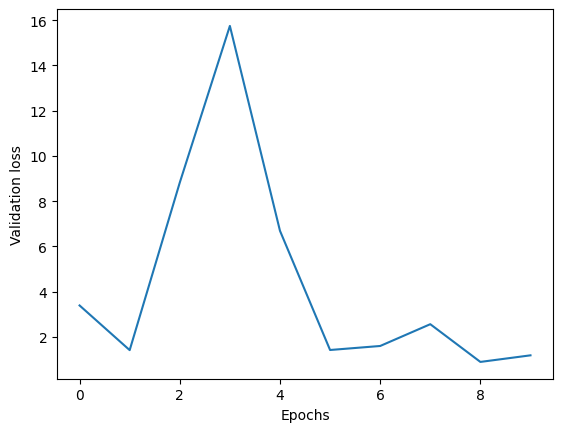

In [28]:
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel("Validation loss")

Text(0, 0.5, 'Validation accuracy')

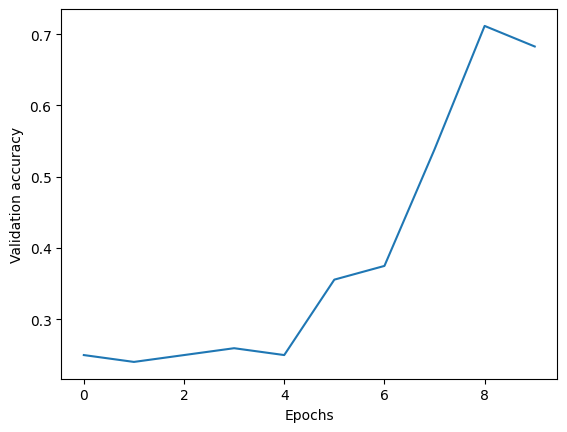

In [29]:
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel("Validation accuracy")